In [38]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import math
from math import log, exp
from scipy.stats import chi2
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics

## Logistic Regression
- predicts categories instead of real numbers (classification)
- Logistic Regression does output a continous number, but that can be converted into a discrete number using threshold
- fairly resiliant against outliers
- the logistic function is a s-curve
- for set of input variables, it produces an output valuable between 0 and 1
- function for 1 input variable x:
- y = 1 / (1 + e**-(ß0 + ß1x))
- ß0 = b = intercept
- ß1 = m = slope
- function in the exponent is the log-odds function
- function for more than 1 input variables:
- y = 1 / (1 + e**-(ß0 + ß1x1 + ß2x2 + ß3x3....))

**Fitting Logistic Regression**
- input data can be decimal, integer or binary
- output has to be binary (0 or 1)
- when we do prediction, output will be between 0 and 1
- given input and output data, we solve for ß0 and ß1
- we dont minimize least squares like in regression
- but we use maximum likelyhood estimation
- which maximizes the likelyhood a given logistic curve would output the observed data

**Preparing and understanding the dataset**

In [2]:
# Load the data
df = pd.read_csv('https://bit.ly/33ebs2R', delimiter=",")

# Extract input variables (all rows, all columns but last column)
X = df.values[:, :-1]

# Extract output column (all rows, last column)
Y = df.values[:, -1]

In [14]:
df.head()

,x,y
0,1.0,0
1,1.5,0
2,2.1,0
3,2.4,0
4,2.5,1


In [15]:
df.describe()

,x,y
count,21.000000,21.000000
mean,5.209524,0.571429
std,2.468786,0.507093
min,1.000000,0.000000
25%,3.100000,0.000000
50%,5.200000,1.000000
75%,7.000000,1.000000
max,9.200000,1.000000


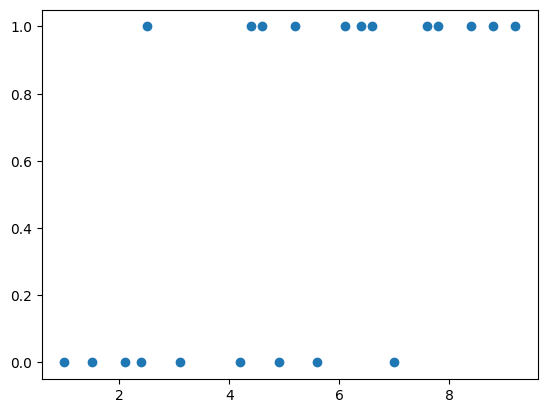

In [17]:
plt.plot(X,Y, "o")
plt.show()

**Logistic regression with sklearn**

In [3]:
# Perform logistic regression
# Turn off penalty
model = LogisticRegression(penalty=None)
model.fit(X, Y)

# print beta1
ß1 = model.coef_.flatten()
print(ß1) # 0.69267212

# print beta0
ß0 = model.intercept_.flatten()
print(ß0) # -3.17576395

[0.69267212]
[-3.17576395]


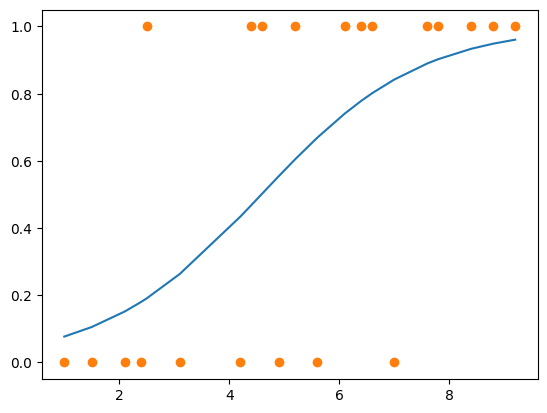

In [4]:
y_hat = model.predict_proba(X)
plt.plot(X, y_hat[:,1])
plt.plot(X,Y,"o")
plt.show()

**Multivariate Logistic Regression**
- multiple input variables
- rest stays the same i think

**Coefficient of determination R squared**
- proportion of variation in the dependent variable that can be explained by the independent variables
- or: How well do the independent variables explain the dependent variables?
- in logistic regression calculated using likelyhoods, not residuals like in linear regression
- so the sklearn method for R squared cant be used for logistic regression

In [12]:
patient_data = list(df.itertuples())

# Declare fitted logistic regression
b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))
    return p

# calculate the log likelihood of the fit
log_likelihood_fit = sum(log(logistic_function(p.x)) * p.y +
                         log(1.0 - logistic_function(p.x)) * (1.0 - p.y)
                         for p in patient_data)

# calculate the log likelihood without fit
likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = sum(log(likelihood) * p.y + log(1.0 - likelihood) * (1.0 - p.y) \
   for p in patient_data)

# calculate R-Square
r2 = (log_likelihood - log_likelihood_fit) / log_likelihood

print(r2)

0.306456105756576


- 0.3 means the input variables are not that good at predicting y. means there are probably other, stronger input variables at play that we do not know about

**P value**
- how likely did we see this data by chance and not because actual relationship
- need chi square distribution: If we take each value in a standard normal distribution and square it, we get chi square distribution

In [15]:
patient_data = list(df.itertuples())

# Declare fitted logistic regression
b0 = -3.17576395
b1 = 0.69267212

def logistic_function(x):
    p = 1.0 / (1.0 + exp(-(b0 + b1 * x)))
    return p

# calculate the log likelihood of the fit
log_likelihood_fit = sum(log(logistic_function(p.x)) * p.y +
                         log(1.0 - logistic_function(p.x)) * (1.0 - p.y)
                         for p in patient_data)

# calculate the log likelihood without fit
likelihood = sum(p.y for p in patient_data) / len(patient_data)

log_likelihood = sum(log(likelihood) * p.y + log(1.0 - likelihood) * (1.0 - p.y) \
                     for p in patient_data)

# calculate p-value
chi2_input = 2 * (log_likelihood_fit - log_likelihood)
p_value = chi2.pdf(chi2_input, 1) # 1 degree of freedom (n - 1)

print(p_value)  # 0.0016604875618753787

0.0016604875618753787


- 0.001... based on significance threshold of 0.05 this data is not by chance

**Train Test splits**
- ml way of evaluating model. r2 and p are statistics way
- ml way better for more variables

In [19]:
# "random_state" is the random seed, which we fix to 7
kfold = KFold(n_splits=3, random_state=7, shuffle=True)
model = LogisticRegression(penalty=None)

results = cross_val_score(model, X, Y, cv=kfold)

print("Accuracy Mean: %.3f (stdev=%.3f)" % (results.mean(), results.std()))

Accuracy Mean: 0.714 (stdev=0.202)


**Confusion matrix**
- better than accuracy to evaluate models when there is class imbalance
- True Positive: Class 1 predicted correctly
- True Negative: Class 2 predicted correctly
- False Positive: Class 1 predicted but is actually Class 2
- False Negative: Class 2 predicted but is actually Class 1
- Recall = TP/(TP + FN) = how many predicted class 1 are actually class 1?
- Precision = TP / (TP + FP) = how many actually class 1 are predicted class 1?
- specifity = TN / (TN + FP) = how many predicted class 2 are actually class 2?
- so: Recall = how good at predicting the positive outcome? Specifity = How good at predicting the negative outcome?

In [21]:
model = LogisticRegression(solver='liblinear')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33,
    random_state=10)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)

matrix = confusion_matrix(y_true=Y_test, y_pred=prediction)
print(matrix)

[[1 3]
 [0 3]]


In [34]:
# pos label basically defines which class is the positive class
precision_recall_fscore_support(y_true=Y_test, y_pred=prediction, pos_label = 0.0, average = "binary")

(1.0, 0.25, 0.4, None)

**Receiver operator characteristics / Area under the curve**
- if there are many classes, or many models to compare, we might end up with a lot of confusion matrices
- can be to cumbersome to review
- plots true positive rate (Recall) vs false positive rate while varying the decision threshold of the model
- ROC curve does not rely on class balance
- curves closer to top left are better
- area under the curve (AUC) is metric that says which is better

In [36]:
kfold = KFold(n_splits=3, random_state=7, shuffle=True)
results = cross_val_score(model, X, Y, cv=kfold, scoring='roc_auc')
print("AUC: %.3f (%.3f)" % (results.mean(), results.std()))

AUC: 0.867 (0.189)


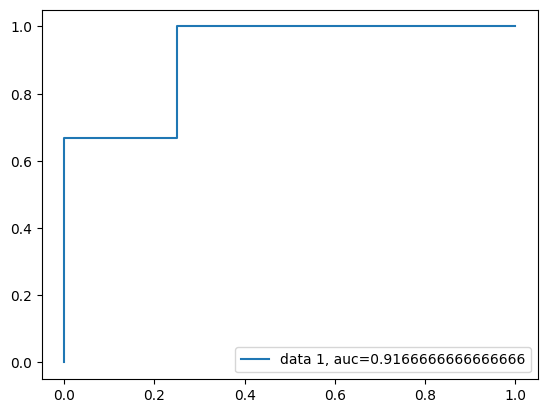

In [48]:
y_pred_proba = model.predict_proba(X_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

**Class imbalance**
- use confusion matrix and ROC
- use resampling methods
- or synthesizing methods

## Exercises

In [70]:
# prepare data
colors = pd.read_csv("https://raw.githubusercontent.com/thomasnield/machine-learning-demo-data/master/classification/light_dark_font_training_set.csv")
colors.head()

X = colors.iloc[:,:-1]
Y = colors.iloc[:,-1]

In [52]:
colors.describe()

,RED,GREEN,BLUE,LIGHT_OR_DARK_FONT_IND
count,1345.000000,1345.000000,1345.000000,1345.000000
mean,159.908550,144.472862,135.873606,0.619331
std,76.959491,71.946756,77.816675,0.485732
min,0.000000,0.000000,0.000000,0.000000
25%,107.000000,95.000000,77.000000,0.000000
50%,173.000000,142.000000,139.000000,1.000000
75%,230.000000,205.000000,205.000000,1.000000
max,255.000000,255.000000,255.000000,1.000000


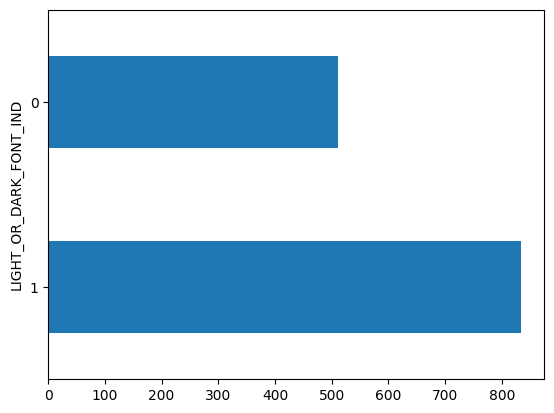

In [62]:
colors.iloc[:,-1].value_counts().plot(kind="barh")
plt.show()

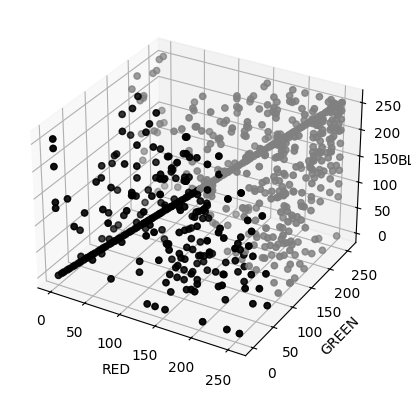

In [69]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

fill = ["black", "grey"]

color= ['black' if l == 0 else 'grey' for l in colors.iloc[:,-1]]

ax.scatter(colors.RED, colors.GREEN, colors.BLUE, color = color)

ax.set_xlabel('RED')
ax.set_ylabel('GREEN')
ax.set_zlabel('BLUE')

plt.show()

In [73]:
# modeling

kfold = KFold(n_splits=3, random_state=7, shuffle=True)
clf = LogisticRegression(penalty=None)

results = cross_val_score(clf, X, Y, cv=kfold)
print(results)


[1. 1. 1.]


In [84]:
clf.fit(X, Y)
Y_pred = clf.predict(X)

conf_matrix = confusion_matrix(y_true=Y, y_pred=Y_pred)
print(conf_matrix)

[[512   0]
 [  0 833]]
